In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import datetime
import matplotlib.pyplot as plt
import cmocean
%matplotlib inline


Create a random spatial SST dataset

In [2]:
lat = np.arange(-35,-30,.1)
lon = np.arange(100,105,.1)
time = pd.date_range("1990-01-01",periods = 365*30)
sst = abs(np.random.randn(lon.size,lat.size,time.size))*20+15+293.7
flag = (np.random.randn(lon.size,lat.size,time.size)*10).round()

In [3]:
data = xr.Dataset(data_vars=dict(sea_surface_temperature=(["lon","lat","time"],sst),flag=(["lon","lat","time"],flag)),coords=dict(lon=("lon",lon),lat=("lat",lat),time = ("time",time)))
data

<xarray.Dataset>
Dimensions:                  (lat: 50, lon: 50, time: 10950)
Coordinates:
  * lon                      (lon) float64 100.0 100.1 100.2 ... 104.8 104.9
  * lat                      (lat) float64 -35.0 -34.9 -34.8 ... -30.2 -30.1
  * time                     (time) datetime64[ns] 1990-01-01 ... 2019-12-24
Data variables:
    sea_surface_temperature  (lon, lat, time) float64 318.6 330.8 ... 340.4
    flag                     (lon, lat, time) float64 2.0 -3.0 -10.0 ... 4.0 2.0

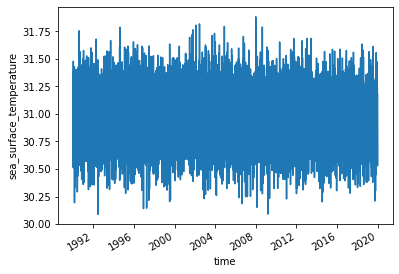

In [4]:
data['sea_surface_temperature'] = data.sea_surface_temperature-293.7 #Kelvin to Celsius conversion
data.sea_surface_temperature.stack(space=['lon','lat']).mean(dim='space').plot();

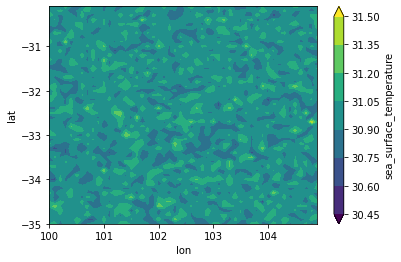

In [5]:
data.sea_surface_temperature.mean(dim='time').plot.contourf(x = 'lon',y='lat',extend='both');


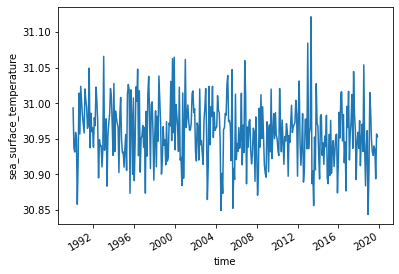

In [6]:
## Resample timeseries (change time increment)
def time_average(da,dt,**kwargs):
    #dt specifies the type of resampling and can take values of 'M', 'Y' or 'DJF' for seasons
    if len(dt)==3:
        quarters = {'DJF':'Q-Feb','MAM':'Q-May','JJA':'Q-Aug','SON':'Q-Nov'}
        mth_num = {'DJF':2,'MAM':5,'JJA':8,'SON':11}
        m = mth_num[dt]
        dt_q = quarters[dt]
        t_unit = 'Y'
        # Method 1: ignores incomplete seasons
        if kwargs['ignore_inc']:
            avg_da=da[kwargs['var']].resample(time=dt_q).mean()
            avg_da = avg_da.sel(time=avg_da['time.month']==m).groupby('time.year').mean()
        else:
        # Method2: replaces incomplete seasons with Na
            avg_da=da[kwargs['var']].resample(time='1M').mean()
            avg_da = da.where(avg_da.time.dt.season==dt).rolling(min_periods=3,center=True,time=3).mean()
            avg_da = avg_da.groupby('time.year').mean('time')[kwargs['var']]
    else:
        t_unit = dt
        dt = '1'+dt
        avg_da=da[kwargs['var']].resample(time=dt).mean()
        avg_da['time'] = avg_da.time.astype('datetime64[' + t_unit +']')
        if not kwargs['ignore_inc']:
            last_day = da.time[(da.time + pd.to_timedelta(1,'D')).dt.month != (da.time).dt.month].astype('datetime64[M]') 
            avg_da = avg_da.where((avg_da.time.isin(last_day) & avg_da.time.isin(da.time)))

    return avg_da

test = time_average(data,'M',var='sea_surface_temperature',ignore_inc = False)
test.stack(space=['lon','lat']).mean(dim='space').plot();

In [7]:
#t = data.to_dataframe()
#t2 = test.to_dataframe()

def save_excel(df_list,file_name = "myfile",*args):
# args can contain a list of the name of sheets (sheetname)
# large spatial daily files can take 10-20mins
    if 'sheetname' in args:
        sheetname = args["sheet_name"]
    else:
        sheetname = list(str(range(1,len(df_list)+1)))
        
    with pd.ExcelWriter(file_name+'.xlsx') as writer:
    
        for i in range(0,len(df_list)):
            if df_list[i].shape[0]>=2**20:
                print("Warning: data #" +str(i)+ " is too large to save as a .xlsx file")
            else:
                df_list[i].to_excel(writer,sheet_name=str(sheetname[i]))

#save_excel([t,t2,t2],file_name="test1")


In [8]:
# Make climatology
def make_clim(da,time_res='month',**kwargs):
    if 'time_slice' in kwargs:
        ct = da.sel(time=slice(kwargs['time_slice'][0],kwargs['time_slice'][1])).groupby('time.' + time_res).count(dim='time')
        s = da.sel(time=slice(kwargs['time_slice'][0],kwargs['time_slice'][1])).groupby('time.' + time_res).std(dim='time')
        clim = da.sel(time=slice(kwargs['time_slice'][0],kwargs['time_slice'][1])).groupby('time.' + time_res).mean(dim='time')
    else:
        clim = da.groupby('time.' + time_res).mean(dim='time')
        s = da.groupby('time.' + time_res).std(dim='time')
        ct = da.groupby('time.' + time_res).count(dim='time')
        
    h95 = clim + 1.96*s/np.sqrt(ct)
    l95 = clim - 1.96*s/np.sqrt(ct)
    return clim,h95,l95


clim = make_clim(data['sea_surface_temperature'],time_res = 'month')


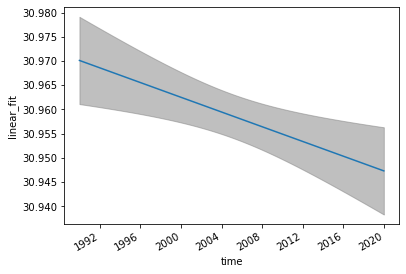

In [73]:
## Fit a linear trend
def lin_trend(da,coord,deg=1):
    
    f=da.polyfit(dim=coord,deg=1)
    fit = xr.polyval(da[coord],f)
    fit = fit.rename({'polyfit_coefficients':'linear_fit'})
    n = len(da[coord])
    x2 = xr.DataArray(range(1,len(da[coord])+1),dims =coord,coords={coord:da[coord]})
    serr= np.sqrt(((da-fit['linear_fit'])**2).sum(dim=coord)/(len(da[coord])-1)).expand_dims(dim = {coord:n})
    t = stats.t.ppf(1-0.025, len(da[coord]))
    B = np.sqrt(1/n + (x2 - np.mean(x2))**2 / np.sum((x2-np.mean(x2))**2))
    ci = B*serr*t
    ci+fit

    hci = ci+fit
    lci = fit-ci
   # f=da.polyfit(dim=coord,deg=1)
   # fit = xr.polyval(da[coord],f)
   # fit = fit.rename({'polyfit_coefficients':'linear_fit'})
   # n = len(da[coord])
   # x2 = range(1,len(da[coord])+1)
   # serr = np.sqrt(np.sum((da-fit)**2)/(len(da[coord])-1))
   # t = stats.t.ppf(1-0.025, len(da[coord]))

    #ci = t * serr['linear_fit'].values * np.sqrt(1/n + (x2 - np.mean(x2))**2 / np.sum((x2-np.mean(x2))**2))
    #hci = ci+fit
    #lci = fit-ci
    return f,fit,hci,lci

coef,fit,hci,lci = lin_trend(data['sea_surface_temperature'].stack(space=['lon','lat']).mean(dim='space'),'time')
fit
fit['linear_fit'].plot()
plt.fill_between(lci['time'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.5,color='grey')


In [74]:
##### Make monthly clim and plot
def Clim_plot(da,time_main,time_res,**kwargs):
    col_yr = ['red', 'blue', 'green', 'yellow', 'purple'] # this could be extended for more years
    
    fig, ax = plt.subplots(figsize=(7, 4))
    clim,h95,l95 = make_clim(da,time_res,time_slice=time_main)
    clim.plot(label='Clim',color = 'black')
    plt.fill_between(h95[time_res],l95,h95,alpha=0.5,color='grey')
    if 'time_recent' in kwargs:
        tt = make_clim(da,time_res,time_slice= kwargs['time_recent'])[0].plot(label='Recent',color = 'black',linestyle='dashed')
    if 'ind_yr' in kwargs:
        ind_yr = kwargs['ind_yr']
        i=0
        for y in kwargs['ind_yr']:
            time_ind_yr = [str(y) +'-01-01', str(y) +'-12-31']
            make_clim(da,time_res,time_slice=time_ind_yr)[0].plot(label=str(y),color = col_yr[i])
            i+=1
            
    xl = clim.coords[time_res].values
    plt.xlim(xl.min(),xl.max())
    if time_res == 'month':
        ax.set_xticks([2,4,6,8,10,12])
        tlab = [datetime.date(1990,x,1).strftime('%b') for x in ax.get_xticks().astype(int) if x > 0 and x <13]
        ax.set_xticklabels([datetime.date(1990,x,1).strftime('%b') for x in [2,4,6,8,10,12]])
    plt.legend(loc = 'lower right')
    return clim,ax
    




Here we plot the annual timeseries and monthly climatology of box average temperatures

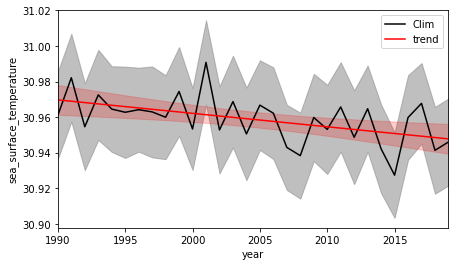

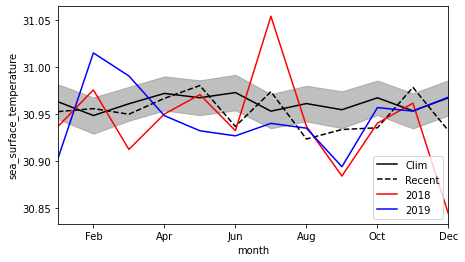

In [75]:
data_bavg = data.stack(space=['lon','lat']).mean(dim='space')

clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2019-12-31'],'year')
ylab = ax.get_ylabel()

coef,fit,hci,lci = lin_trend(clim,'year')
fit['linear_fit'].plot(ax=ax,color='red',label = 'trend')
plt.fill_between(lci['year'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.2,color='red')
ax.set_ylabel(ylab)
plt.legend()

clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2010-12-31'],'month',time_recent = ['2011-01-01', None],ind_yr = [2018 ,2019])

#Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2010-12-31'],'month',time_recent = ['2011-01-01', None],ind_yr = [2019])


<GeoAxesSubplot:title={'center':'Map'}, xlabel='lon', ylabel='lat'>

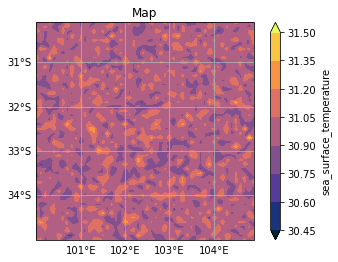

In [116]:
## correct mapping
def map(da,lim_lon,lim_lat,cmap,title = 'Map'):
    import cartopy.crs as ccrs
    import cartopy
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    ax.add_feature(cartopy.feature.LAND,color = 'grey',edgecolor = 'black')
    da.plot.contourf(x = 'lon',y='lat',extend='both',cmap=cmap,ax=ax)
    ax.set_extent(lim_lon+lim_lat)
    ax.set_title(title);
    return ax

map(data.sea_surface_temperature.mean(dim='time'),[data.lon.min(),data.lon.max()],[data.lat.min(),data.lat.max()],cmap = cmocean.cm.thermal)



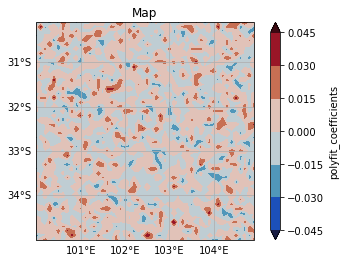

In [92]:
#Map linear trends
clim = make_clim(data['sea_surface_temperature'],time_res = 'year')
coef,fit,hci,lci= lin_trend(clim[0],'year',deg=1)
coef.isel(degree=0)['polyfit_coefficients']

map(coef.isel(degree=0)['polyfit_coefficients'],[coef.lon.min(),coef.lon.max()],[coef.lat.min(),coef.lat.max()],cmap = cmocean.cm.balance)



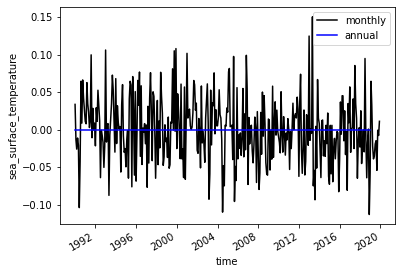

In [98]:
# Map and plot SST anomaly

# Make monthly anomalies
mn_ano = time_average(data,'M',var='sea_surface_temperature',ignore_inc = True).groupby('time.month') - make_clim(data['sea_surface_temperature'],time_res = 'month')[0]
mn_ano.stack(space=['lon','lat']).mean(dim='space').plot(label='monthly',color='black');
# Make yearly anomalies
yr_ano = time_average(data,'Y',var='sea_surface_temperature',ignore_inc = True).groupby('time.year') - make_clim(data['sea_surface_temperature'],time_res = 'year')[0]
yr_ano.stack(space=['lon','lat']).mean(dim='space').plot(label='annual',color='blue');
plt.legend()


<GeoAxesSubplot:title={'center':'SST anomaly 1991-Feb'}, xlabel='lon', ylabel='lat'>

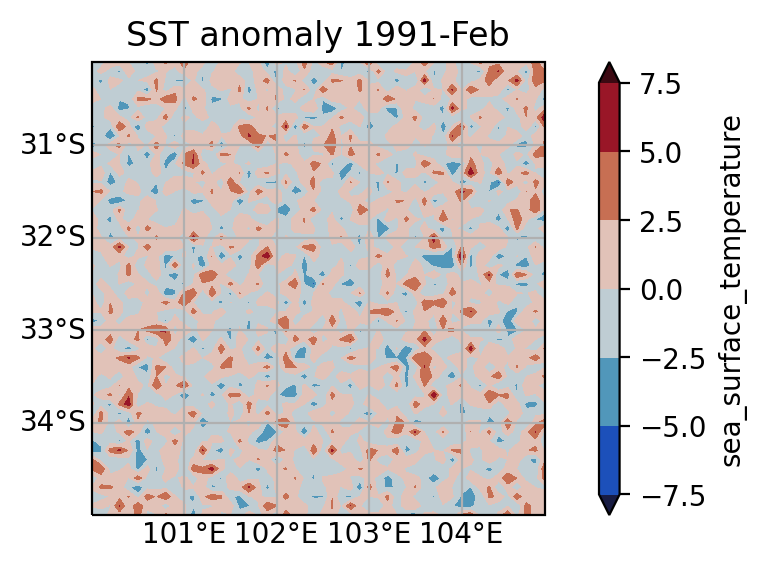

In [118]:
fig, axe = plt.subplots(2,5,figsize=(7,3), dpi=200)
y = 1991
ax = map(mn_ano.sel(time=str(y) +'-02-01'),[mn_ano.lon.min(),mn_ano.lon.max()],[mn_ano.lat.min(),mn_ano.lat.max()],cmap = cmocean.cm.balance,title = 'SST anomaly '+str(y) +'-Feb')
ax
#i = 0
#for y in range(1990,10,1):
#    axe[0].map(mn_ano.sel(time=str(y) +'-02-01'),[mn_ano.lon.min(),mn_ano.lon.max()],[mn_ano.lat.min(),mn_ano.lat.max()],cmap = cmocean.cm.balance,title = 'SST anomaly '+str(y) +'-Feb')
#    i+=1

In [121]:
ax
#fig, axe = plt.subplots(2,5,figsize=(7,3), dpi=200)
#axe[1,1]=ax

<GeoAxesSubplot:title={'center':'SST anomaly 1991-Feb'}, xlabel='lon', ylabel='lat'>